Using device: mps
Training PixelCNN on MNIST...
Epoch 1/5, NLL = 0.1142
Epoch 2/5, NLL = 0.0833
Epoch 3/5, NLL = 0.0819
Epoch 4/5, NLL = 0.0813
Epoch 5/5, NLL = 0.0809
Test NLL = 62.9772
Sampling from PixelCNN...


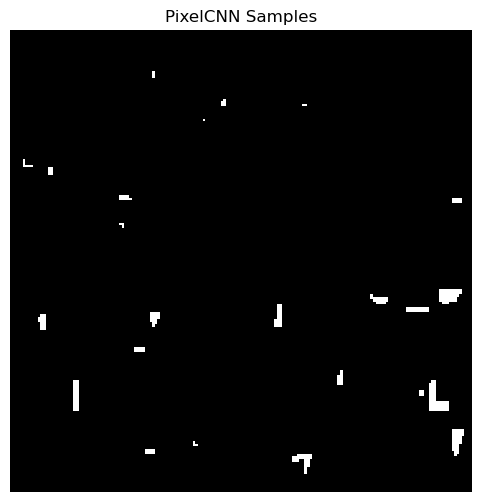

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# 1) Hyperparameters
# -----------------------
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available() 
                      else 'cpu')

# -----------------------
# 2) Data: MNIST
# -----------------------
transform = transforms.Compose([
    transforms.ToTensor()   # yields a tensor in [0,1]
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Each sample is shape (1, 28, 28).  We keep it in 2D form for PixelCNN.

# ------------------------------------------------------
# 3) Masked Convolution: The Core of PixelCNN
# ------------------------------------------------------
class MaskedConv2d(nn.Conv2d):
    """
    A 2D convolution where the kernel is masked so that 
    the output pixel cannot depend on 'future' pixels.

    mask_type: 'A' or 'B'
      - 'A' is used for the first conv layer so it doesn't see the current pixel.
      - 'B' is used for subsequent layers; it can see the current pixel but not future ones.
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, 
                 stride=1, padding=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size=kernel_size,
                         stride=stride, padding=padding, dilation=dilation, 
                         groups=groups, bias=bias)
        assert mask_type in ['A','B'], "mask_type must be 'A' or 'B'"
        self.mask_type = mask_type
        
        # Register buffer for the mask
        self.register_buffer('mask', torch.ones_like(self.weight.data))

    def _create_mask(self):
        # The shape of weight is (out_channels, in_channels, kH, kW).
        kH, kW = self.kernel_size
        # The center pixel in the kernel
        center_h = kH // 2
        center_w = kW // 2

        # Construct a mask of ones, then zero out "future" pixels.
        mask = torch.ones_like(self.weight.data)

        # For every output channel, for every input channel, for every kernel row/col:
        # We want to zero out the pixels that are below or to the right of the "current" pixel.
        # Actually, we zero out the center pixel itself only if mask_type=='A'.
        
        # Indices:
        #   everything in row > center_h is future
        #   everything in row == center_h and col > center_w is future
        # If mask_type='A', also block the center pixel (center_h, center_w).
        
        mask[:, :, center_h, center_w+1:] = 0  # zero out right half of center row
        mask[:, :, center_h+1:, :] = 0        # zero out rows below the center

        if self.mask_type == 'A':
            # also zero out the center pixel
            mask[:, :, center_h, center_w] = 0

        return mask

    def forward(self, x):
        # Make sure our stored 'mask' is up to date
        if self.mask.sum() == self.mask.numel():  
            # i.e. if we haven't yet built it
            with torch.no_grad():
                self.mask.copy_(self._create_mask())

        # apply the mask
        self.weight.data *= self.mask
        return super().forward(x)

# ------------------------------------------------------
# 4) PixelCNN Model
# ------------------------------------------------------
class PixelCNN(nn.Module):
    """
    A simple PixelCNN:
      - First layer is MaskedConv with 'A'
      - Then several MaskedConv with 'B'
      - We output 1 channel of logits for each pixel (Bernoulli).
    """
    def __init__(self, hidden_channels=64, kernel_size=3, num_layers=5):
        super().__init__()
        self.num_layers = num_layers

        # First layer: type 'A' 
        self.conv1 = MaskedConv2d(
            in_channels=1, out_channels=hidden_channels, 
            kernel_size=kernel_size, mask_type='A', 
            padding=kernel_size//2
        )

        # Middle layers: type 'B'
        self.mid_convs = nn.ModuleList()
        for _ in range(num_layers - 2):
            self.mid_convs.append(
                MaskedConv2d(hidden_channels, hidden_channels, 
                             kernel_size=kernel_size, mask_type='B', 
                             padding=kernel_size//2)
            )

        # Last layer: also type 'B', but output 1 channel 
        # (Bernoulli => each pixel has a single logit)
        self.conv_out = MaskedConv2d(
            hidden_channels, 1, 
            kernel_size=kernel_size, mask_type='B',
            padding=kernel_size//2
        )

    def forward(self, x):
        # x is shape (B,1,28,28), in [0,1]
        out = F.relu(self.conv1(x))
        for c in self.mid_convs:
            out = F.relu(c(out))
        out = self.conv_out(out)
        # shape = (B,1,28,28).  Interpreted as logits for Bernoulli p.
        return out

# ------------------------------------------------------
# 5) Training
# ------------------------------------------------------
def train_pixelcnn(model, train_loader, optimizer, epochs=5):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(DEVICE)  # shape (B,1,28,28)
            optimizer.zero_grad()
            
            logits = model(images)  # shape (B,1,28,28)
            # Bernoulli NLL with logits => use F.binary_cross_entropy_with_logits
            loss = F.binary_cross_entropy_with_logits(
                logits, images, reduction='mean'
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}/{epochs}, NLL = {avg_loss:.4f}")

# ------------------------------------------------------
# 6) Testing (optional, we can measure NLL on test set)
# ------------------------------------------------------
def eval_pixelcnn(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            logits = model(images)
            loss = F.binary_cross_entropy_with_logits(
                logits, images, reduction='sum'
            )
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

# ------------------------------------------------------
# 7) Sampling
# ------------------------------------------------------
def sample_from_pixelcnn(model, n=8):
    """
    Autoregressive sampling.  
    We create an empty canvas (B= n^2, 1, 28, 28) 
    and fill it in one pixel at a time, left-to-right, top-to-bottom.
    """
    model.eval()
    samples = torch.zeros(n*n, 1, 28, 28).to(DEVICE)

    # We must fill each pixel [row,col] in order.
    for row in range(28):
        for col in range(28):
            with torch.no_grad():
                out = model(samples)  # shape (B,1,28,28) => logits
                # get the current pixel's logits
                logits = out[:, 0, row, col]
                probs = torch.sigmoid(logits)
                # sample from Bernoulli
                pixel_value = torch.bernoulli(probs)
                samples[:, 0, row, col] = pixel_value
    return samples.detach().cpu()

# ------------------------------------------------------
# 8) Main Script
# ------------------------------------------------------
if __name__ == "__main__":
    print("Using device:", DEVICE)
    model = PixelCNN(hidden_channels=64, kernel_size=3, num_layers=5).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    print("Training PixelCNN on MNIST...")
    train_pixelcnn(model, train_loader, optimizer, epochs=EPOCHS)

    test_nll = eval_pixelcnn(model, test_loader)
    print(f"Test NLL = {test_nll:.4f}")

    # Generate samples
    print("Sampling from PixelCNN...")
    sampled_imgs = sample_from_pixelcnn(model, n=6)  # 6x6 grid => 36 samples

    # Plot them
    grid_img = utils.make_grid(sampled_imgs, nrow=6, padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid_img[0].numpy(), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title("PixelCNN Samples")
    plt.show()
